# Задание ZALA  
## 2. Детектирование множества объектов

__YOLOv8n__ (Ultralytics YOLOv8 Nano) – самый лёгкий вариант, быстрый.  

__MobileNetV3-SSD__ – лёгкая модель для детекции. 

__EfficientDet-D0__ – баланс качества и скорости. 

__NanoDet / PP-YOLOE-S__ – быстрые и эффективные.  

In [1]:
# !pip install fvcore

#!pip install torchprofile -q

## Импорты

In [ ]:
import time
from glob import glob
import os 
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import pickle  
from PIL import Image 

import xml.etree.ElementTree as ET  

import torch 
from torchsummary import summary
import torchvision  
from torchvision.models.detection import ssdlite320_mobilenet_v3_large  
import torch.optim as optim  
from torch.utils.data import DataLoader  
from torch.utils.data import Dataset  
import torchvision.transforms as transforms 
from torch.utils.data import random_split



 




import warnings
warnings.filterwarnings("ignore")


print('Виртуальное окружение')
!which python 
# Текущее положение
print('\nТекущее положение: ')
path_1 = os.getcwd()
print(path_1)

Виртуальное окружение
/home/maksim/anaconda3/envs/rapids-25.02/bin/python

Текущее положение: 
/home/maksim/develops/python/devsTraining/zala_task


In [3]:
# устанавливаем device если gpu или cpu
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print("работаем на устройстве: ", device)
print('Версия torch:           ', torch.__version__)
print("версия  cuDNN:          ", torch.backends.cudnn.version())

# ПРОВЕРКА GPU
!nvidia-smi

работаем на устройстве:  cuda
Версия torch:            2.6.0+cu124
версия  cuDNN:           90100
Mon Mar 24 14:04:06 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.120                Driver Version: 550.120        CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060        Off |   00000000:01:00.0  On |                  N/A |
|  0%   54C    P8             22W /  170W |     678MiB /  12288MiB |     38%      Default |
|                                         

## Обработка данных

In [4]:

# Пути к файлам
yolo_labels_dir = "datasets/labels/train"
output_json = "datasets/annotations/train.json"

# # Структура COCO
# coco_data = {
#     "images": [],
#     "annotations": [],
#     "categories": []
# }

# # Категории (добавь свои классы)
# category_mapping = {
#     0: "building",
#     1: "cable-tower",
#     2: "cultivation-mesh-cage",
#     3: "landslide",
#     4: "pool",
#     5: "prefabricated-house",
#     6: "quarry",
#     7: "ship",
#     8: "vehicle",
#     9: "well"
# }

# # Добавляем категории
# for class_id, name in category_mapping.items():
#     coco_data["categories"].append({
#         "id": class_id,
#         "name": name,
#         "supercategory": "object"
#     })

# # Обрабатываем YOLO файлы
# annotation_id = 0
# image_id = 0
# for txt_file in glob(os.path.join(yolo_labels_dir, "*.txt")):
#     image_name = os.path.basename(txt_file).replace(".txt", ".jpg")
#     image_path = os.path.join("datasets/images/train", image_name)

#     if not os.path.exists(image_path):
#         continue  # Если изображения нет, пропускаем

#     # Добавляем изображение в COCO
#     coco_data["images"].append({
#         "id": image_id,
#         "file_name": image_name,
#         "width": 1024,  # Укажи своё разрешение
#         "height": 1024
#     })

#     # Загружаем аннотации из YOLO
#     with open(txt_file, "r") as f:
#         lines = f.readlines()

#     for line in lines:
#         values = line.strip().split()
#         class_id = int(values[0])
#         x, y, w, h = map(float, values[1:])

#         # YOLO -> COCO bbox
#         coco_data["annotations"].append({
#             "id": annotation_id,
#             "image_id": image_id,
#             "category_id": class_id,
#             "bbox": [
#                 (x - w / 2) * 1024,  # Пересчет координат
#                 (y - h / 2) * 1024,
#                 w * 1024,
#                 h * 1024
#             ],
#             "area": w * h * 1024 * 1024,
#             "iscrowd": 0
#         })
#         annotation_id += 1

#     image_id += 1

# # Сохраняем в JSON
# with open(output_json, "w") as f:
#     json.dump(coco_data, f, indent=4)

# print(f"✅ Файл COCO-сет train.json сохранён в {output_json}")


## Обучение

In [38]:

def collate_fn(batch):
    images, targets = zip(*batch)  # Разбираем батч
    return list(images), list(targets)  # Оставляем списками (без stack)


In [40]:
class PascalVOCDataset(Dataset):  
    def __init__(self, images_dir, annotations_dir, transform=None):  
        self.images_dir = images_dir  
        self.annotations_dir = annotations_dir  
        self.image_filenames = os.listdir(images_dir)  
        self.transform = transform  

    def __len__(self):  
        return len(self.image_filenames)  

    def __getitem__(self, idx):  
        # Получение имени файла изображения  
        img_name = self.image_filenames[idx]  
        img_path = os.path.join(self.images_dir, img_name)  

        # Загрузка изображения  
        image = Image.open(img_path).convert("RGB")  
        
        # Загрузка аннотации  
        annotation_path = os.path.join(self.annotations_dir, img_name.replace('.jpg', '.xml'))  
        boxes, labels = self.parse_annotation(annotation_path)  

        # Применение преобразований, если указаны  
        if self.transform:  
            image = self.transform(image)  

        return image, {  
            'boxes': torch.tensor(boxes, dtype=torch.float32),  
            'labels': torch.tensor(labels, dtype=torch.int64)  
        }  

    def label_to_id(self, label):  
        label_mapping = {
            'building': 0,  
            'cable-tower': 1,  
            'cultivation-mesh-cage': 2,  
            'landslide': 3,  
            'pool': 4,  
            'prefabricated-house': 5,  
            'quarry': 6,  
            'ship': 7,  
            'vehicle': 8,  
            'well': 9  
        }  
        return label_mapping.get(label, -1)  # -1 если вдруг неизвестный класс

    
    def parse_annotation(self, annotation_path):
        boxes = []
        labels = []

        try:
            tree = ET.parse(annotation_path)
            root = tree.getroot()

            for obj in root.findall('object'):
                label = obj.find('name').text
                label_id = self.label_to_id(label)

                bndbox = obj.find('bndbox')
                xmin = float(bndbox.find('xmin').text)
                ymin = float(bndbox.find('ymin').text)
                xmax = float(bndbox.find('xmax').text)
                ymax = float(bndbox.find('ymax').text)

                # Проверяем координаты
                if xmin >= xmax or ymin >= ymax:
                    print(f"Warning: Invalid bbox in {annotation_path}: {xmin, ymin, xmax, ymax}")
                    continue  # Пропускаем такие боксы

                boxes.append([xmin, ymin, xmax, ymax])
                labels.append(label_id)

        except Exception as e:
            print(f"Error parsing {annotation_path}: {e}")

        return boxes, labels


# Применяем преобразования  
transform = transforms.Compose([  
    transforms.Resize((512, 512)),  
    transforms.ToTensor()  
])  

# Создаем датасет  
images_dir = 'dataset/image/'  
annotations_dir = 'dataset/target/'  
dataset = PascalVOCDataset(images_dir, annotations_dir, transform=transform)  

# Пример использования DataLoader  
from torch.utils.data import DataLoader  




# Доли выборки (например, 80% train / 20% val)
train_ratio = 0.8
val_ratio = 1 - train_ratio

# Определяем размеры
dataset_size = len(dataset)
train_size = int(train_ratio * dataset_size)
val_size = dataset_size - train_size  # Остаток на валидацию

# Разделяем датасет
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Проверим размеры
print(f"Train size: {len(train_dataset)}, Val size: {len(val_dataset)}")






train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn)


Train size: 675, Val size: 169


In [42]:
num_epochs = 10
learning_rate = 0.001  # Скорость обучения  
weight_decay=0.0005

# Загрузка предобученной модели  
model = ssdlite320_mobilenet_v3_large(pretrained=True)  
model.to(device)  # Переводим модель на устройство  
model.train()  # Устанавливаем модель в режим обучения  

# Настройка оптимизатора  
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=weight_decay) 
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)


model = ssdlite320_mobilenet_v3_large(pretrained=False)  # Создаём модель
model.load_state_dict(torch.load("model.pth", map_location=device))  # Загружаем веса
model.to(device);

In [30]:
for epoch in range(num_epochs):  
    total_loss = 0  
    for images, targets in data_loader:  
        images = list(image.to(device) for image in images)  
        
        # Обработка аннотаций для целевых переменных  
        targets = [{k: v.to(device) for k, v in target.items()} for target in targets]  

        # Проверка рамок на валидность  
        valid_targets = []  
        invalid_boxes = 0  

        for target in targets:  
            boxes = target['boxes'].cpu().numpy()  # Переводим на CPU для проверки  
            valid = True  
            
            for box in boxes:  
                x_min, y_min, x_max, y_max = box  
                if x_min >= x_max or y_min >= y_max:  
                    valid = False  
                    invalid_boxes += 1  
                    print(f"Invalid box found: {box}")  # Выводим информацию о неправильной рамке  
                    break  
            
            if valid:  
                valid_targets.append(target)  
            else:  
                valid_targets.append({  
                    'boxes': torch.tensor([[0, 0, 0, 0]], dtype=torch.float32).to(device),  
                    'labels': torch.tensor([0], dtype=torch.int64).to(device)  
                })  

        # Если нет валидных целей, пропускаем итерацию  
        if len(valid_targets) == 0:  
            print("No valid targets found for this batch.")  
            continue  

        # Обнуляем градиенты  
        optimizer.zero_grad()  
        
        # Прямой проход (forward pass)  
        try:  
            loss_dict = model(images, valid_targets)  
        except Exception as e:  
            print(f"Error during training: {e}")  
            continue  
            
        # Вычисляем общую потерю  
        losses = sum(loss for loss in loss_dict.values())  
        
        # Обратный проход (backward pass) и обновление весов  
        losses.backward()  
        optimizer.step()  
        
        total_loss += losses.item()  # Суммируем потери для мониторинга  

    # Печать информации о текущей эпохе  
    print(f"Epoch [{epoch + 1}/{num_epochs}] Loss: {total_loss / len(data_loader):.4f}")  
    
torch.save(model.state_dict(), "model.pth")
    

Epoch [1/10] Loss: 20.9586
Epoch [2/10] Loss: 22.8909
Epoch [3/10] Loss: 22.1463
Epoch [4/10] Loss: 21.5311
Epoch [5/10] Loss: 22.6307
Epoch [6/10] Loss: 22.1821
Epoch [7/10] Loss: 20.8133
Epoch [8/10] Loss: 22.3420
Epoch [9/10] Loss: 22.4242
Epoch [10/10] Loss: 23.2020


In [ ]:
import torch
import torch.nn.functional as F

def ssd_criterion(output, targets):
    """
    Функция потерь для SSD, аналогичная той, что используется в ssdlite320_mobilenet_v3_large.
    
    output  - предсказания модели (список словарей с "boxes" и "scores")
    targets - истинные метки (список словарей с "boxes" и "labels")
    
    Возвращает сумму Smooth L1 Loss для регрессии координат и CrossEntropy Loss для классификации.
    """
    bbox_loss = 0
    class_loss = 0
    num_samples = len(output)
    print("CRITERION")
    print(num_samples)

    for i in range(num_samples):
        pred_boxes = output[i]['boxes']  # Предсказанные боксы
        pred_scores = output[i]['scores']  # Предсказанные вероятности классов

        target_boxes = targets[i]['boxes']  # Истинные боксы
        target_labels = targets[i]['labels']  # Истинные классы

        # Проверяем, есть ли хоть один объект в таргете
        if target_boxes.shape[0] == 0:
            continue  # Пропускаем пустые примеры
        print(pred_boxes.shape)
        print("3------------------333")
        print(target_boxes.shape)
        # Регрессионная потеря: Smooth L1 Loss (Huber Loss)
        bbox_loss += F.smooth_l1_loss(pred_boxes, target_boxes, reduction='sum')
        # Классификационная потеря: CrossEntropy Loss
        class_loss += F.cross_entropy(pred_scores, target_labels, reduction='sum')
    # Усредняем по батчу
    total_loss = (bbox_loss + class_loss) / num_samples if num_samples > 0 else 0
    return total_loss


In [92]:
import torch
import torch.nn.functional as F

def match_pred_to_target(pred_boxes, pred_scores, target_boxes, target_labels, iou_threshold=0.5):
    """
    Функция для сопоставления предсказанных боксов с реальными.
    Использует IoU, чтобы найти наилучшие соответствия.
    """
    from torchvision.ops import box_iou

    if target_boxes.shape[0] == 0:
        return None, None  # Если нет объектов, ничего не делаем

    iou_matrix = box_iou(pred_boxes, target_boxes)  # Вычисляем IoU между предсказанными и реальными боксами
    max_iou, matched_idx = iou_matrix.max(dim=1)  # Берём максимальные соответствия
    # Оставляем только боксы с IoU > порога
    valid = max_iou > iou_threshold
    matched_boxes = target_boxes[matched_idx[valid]]
    matched_labels = target_labels[matched_idx[valid]]

    return matched_boxes, matched_labels

def ssd_criterion(output, targets):
    bbox_loss = 0
    class_loss = 0
    num_samples = len(output)

    for i in range(num_samples):
        pred_boxes = output[i]['boxes']  # (300, 4)
        pred_scores = output[i]['scores']  # (300,)

        target_boxes = targets[i]['boxes']  # (N, 4)
        target_labels = targets[i]['labels']  # (N,)
    
        matched_boxes, matched_labels = match_pred_to_target(pred_boxes, pred_scores, target_boxes, target_labels)

        if matched_boxes is None:
            continue  # Пропускаем пустые примеры

   
        # Smooth L1 Loss (Huber Loss) для координат боксов
        bbox_loss += F.smooth_l1_loss(pred_boxes[:matched_boxes.shape[0]], matched_boxes, reduction='sum')
   

 


        # CrossEntropy Loss для классов (нужно привести предсказания в правильную форму)
        # class_loss += F.cross_entropy(pred_scores[:matched_labels.shape[0]], matched_labels.long(), reduction='sum')

        num_classes = 91  # Укажите число классов в вашей модели

        # Проверяем, что pred_scores имеет форму (N, num_classes)
        if pred_scores.dim() == 1:
            pred_scores = pred_scores.unsqueeze(1)  # Делаем (N, 1)
            pred_scores = pred_scores.expand(-1, num_classes)  # Расширяем до (N, num_classes)

        # Убеждаемся, что `target_labels` является float-типа
        target_labels = target_labels.to(dtype=torch.long)

        # Подгоняем target_labels по размеру к pred_scores
        num_preds = pred_scores.shape[0]
        num_targets = target_labels.shape[0]

        if num_preds > num_targets:
            # Заполняем target_labels -1, чтобы исключить их при расчёте loss
            target_labels_padded = torch.full((num_preds,), -1, dtype=torch.long, device=pred_scores.device)
            target_labels_padded[:num_targets] = target_labels
        else:
            target_labels_padded = target_labels[:num_preds]  # Обрезаем лишнее

        # Применяем cross_entropy только к валидным меткам
        valid_mask = target_labels_padded != -1
        class_loss += F.cross_entropy(pred_scores[valid_mask], target_labels_padded[valid_mask], reduction='sum')

    


        # class_loss += F.cross_entropy(pred_scores[:matched_labels.shape[0]], matched_labels, reduction='sum')

    total_loss = (bbox_loss + class_loss) / num_samples if num_samples > 0 else 0
    return total_loss


In [93]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from torchvision.models.detection import ssdlite320_mobilenet_v3_large
from torchvision.ops import box_iou


# Гиперпараметры
num_epochs = 10
learning_rates = [0.005, 0.001, 0.0001]
optimizers_list = ['SGD', 'Adam', "AdamW", "Adagrad", "ASGD", "Adadelta"]
momentum = 0.9
weight_decay = 0.0005

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Функция вычисления IoU
def calculate_iou(pred_boxes, target_boxes):
    if len(pred_boxes) == 0 or len(target_boxes) == 0:
        return 0
    iou = box_iou(pred_boxes, target_boxes).mean().item()
    return iou

# Результаты
results = {}
# Загружаем модель
model = ssdlite320_mobilenet_v3_large(pretrained=True).to(device)
# Перебор гиперпараметров
for opt_type in optimizers_list:
    for lr in learning_rates:
        print(f"\nТренировка {opt_type}, LR : {lr}")


        model.train()

        # Оптимизатор
        if opt_type == "SGD":
            optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
        elif opt_type == "Adam":
            optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        elif opt_type == "AdamW":
            optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
        elif opt_type == "Adagrad":
            optimizer = optim.Adagrad(model.parameters(), lr=lr)
        elif opt_type == "ASGD":
            optimizer = optim.ASGD(model.parameters(), lr=lr)
        elif opt_type == "Adadelta":
            optimizer = optim.Adadelta(model.parameters(), lr=lr)

        train_losses, val_losses = [], []
        train_iou_scores, val_iou_scores = [], []

        # Обучение модели
        for epoch in range(num_epochs):
            total_train_loss, total_val_loss = 0, 0
            total_train_iou, total_val_iou = 0, 0
            num_train_batches, num_val_batches = 0, 0

            # ======= ТРЕНИРОВКА =======
            model.train()
            for images, targets in train_loader:
                images = [img.to(device) for img in images]
                valid_targets = [{'boxes': t['boxes'].to(device), 'labels': t['labels'].to(device)} for t in targets]

                optimizer.zero_grad()
                try:
                    loss_dict = model(images, valid_targets)
                    loss = sum(loss for loss in loss_dict.values())
                    loss.backward()
                    optimizer.step()

                    total_train_loss += loss.item()
                    num_train_batches += 1

                    # IoU оценка
                    with torch.no_grad():
                        model.eval()
                        output = model(images)
                        model.train()

                        for i, out in enumerate(output):
                            pred_boxes = out['boxes'].detach()
                            target_boxes = valid_targets[i]['boxes'].detach()
                            iou = calculate_iou(pred_boxes, target_boxes)
                            total_train_iou += iou

                except Exception as e:
                    print(f"Ошибка в обучении: {e}")
                    continue

            avg_train_loss = total_train_loss / num_train_batches
            avg_train_iou = total_train_iou / num_train_batches
            train_losses.append(avg_train_loss)
            train_iou_scores.append(avg_train_iou)



            # === ВАЛИДАЦИЯ ===
            model.train(False)  # Отключаем BatchNorm и Dropout
            model.eval()  # Включаем режим валидации
            # Включаем режим валидации
            total_val_loss = 0
            total_val_iou = 0
            num_val_batches = 0

            with torch.no_grad():  # Отключаем градиенты
                for images, targets in val_loader:
                    images = [img.to(device) for img in images]
                    valid_targets = [{'boxes': t['boxes'].to(device), 'labels': t['labels'].to(device)} for t in targets]

                    try:
                        output = model(images)


                        # Получаем потери
                        loss = ssd_criterion(output, valid_targets)  # Используем предсказания

                        total_val_loss += loss.item()

                        # Оценка IoU
                        for i, out in enumerate(output):
                            pred_boxes = out['boxes'].detach()
                            target_boxes = valid_targets[i]['boxes'].detach()

                            iou = calculate_iou(pred_boxes, target_boxes)
                            total_val_iou += iou

                        num_val_batches += 1

                    except Exception as e:
                        print(f"Ошибка в валидации: {e}")
                        continue

            # Избегаем деления на ноль
            if num_val_batches > 0:
                avg_val_loss = total_val_loss / num_val_batches
                avg_val_iou = total_val_iou / num_val_batches
            else:
                avg_val_loss = 0
                avg_val_iou = 0

            val_losses.append(avg_val_loss)
            val_iou_scores.append(avg_val_iou)
            

            print(f"Epoch [{epoch+1}/{num_epochs}] Train Loss: {avg_train_loss:.4f}, Train IoU: {avg_train_iou:.4f} | "
                f"Val Loss: {avg_val_loss:.4f}, Val IoU: {avg_val_iou:.4f}")





# Визуализация графиков
plt.figure(figsize=(12, 5))

# График потерь
plt.subplot(1, 2, 1)
for key, (train_losses, val_losses, _, _) in results.items():
    plt.plot(range(1, num_epochs + 1), train_losses, label=f"{key} (train)")
    plt.plot(range(1, num_epochs + 1), val_losses, label=f"{key} (val)", linestyle="dashed")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.legend()

# График IoU
plt.subplot(1, 2, 2)
for key, (_, _, train_ious, val_ious) in results.items():
    plt.plot(range(1, num_epochs + 1), train_ious, label=f"{key} (train)")
    plt.plot(range(1, num_epochs + 1), val_ious, label=f"{key} (val)", linestyle="dashed")
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.title('IoU per Epoch')
plt.legend()

plt.show()



Тренировка SGD, LR : 0.01
Epoch [1/10] Train Loss: 32.5722, Train IoU: 0.0052 | Val Loss: 473.4673, Val IoU: 0.0069
Epoch [2/10] Train Loss: 28.7094, Train IoU: 0.0051 | Val Loss: 535.3072, Val IoU: 0.0062
Epoch [3/10] Train Loss: 26.9340, Train IoU: 0.0055 | Val Loss: 529.6581, Val IoU: 0.0070
Epoch [4/10] Train Loss: 25.8243, Train IoU: 0.0060 | Val Loss: 496.1931, Val IoU: 0.0068
Epoch [5/10] Train Loss: 24.7290, Train IoU: 0.0051 | Val Loss: 440.0052, Val IoU: 0.0058
Epoch [6/10] Train Loss: 22.8172, Train IoU: 0.0050 | Val Loss: 618.0122, Val IoU: 0.0074
Epoch [7/10] Train Loss: 24.0530, Train IoU: 0.0056 | Val Loss: 501.1530, Val IoU: 0.0082
Epoch [8/10] Train Loss: 23.8447, Train IoU: 0.0049 | Val Loss: 376.1586, Val IoU: 0.0057
Epoch [9/10] Train Loss: 26.2902, Train IoU: 0.0055 | Val Loss: 433.6467, Val IoU: 0.0056
Epoch [10/10] Train Loss: 24.1685, Train IoU: 0.0048 | Val Loss: 325.0147, Val IoU: 0.0053

Тренировка SGD, LR : 0.005
Epoch [1/10] Train Loss: 25.2094, Train IoU:

KeyboardInterrupt: 

In [ ]:
# === ВАЛИДАЦИЯ ===
model.eval()  # Включаем режим валидации
total_val_loss = 0
total_val_iou = 0
num_val_batches = 0

with torch.no_grad():  # Отключаем градиенты
    for images, targets in val_loader:
        images = [img.to(device) for img in images]
        valid_targets = [{'boxes': t['boxes'].to(device), 'labels': t['labels'].to(device)} for t in targets]

        try:
            output = model(images)  # Только предсказания, без targets

            # Оценка IoU
            for i, out in enumerate(output):
                pred_boxes = out['boxes'].detach()
                target_boxes = valid_targets[i]['boxes'].detach()

                iou = calculate_iou(pred_boxes, target_boxes)
                total_val_iou += iou

            num_val_batches += 1

        except Exception as e:
            print(f"Ошибка в валидации: {e}")
            continue

# Избегаем деления на ноль
if num_val_batches > 0:
    avg_val_iou = total_val_iou / num_val_batches
else:
    avg_val_iou = 0

val_iou_scores.append(avg_val_iou)
print(f"Validation IoU: {avg_val_iou:.4f}")



Training with SGD, Learning Rate: 0.005
Epoch [1/10] Loss: 30.6225, IoU: 0.0114
Epoch [2/10] Loss: 19.5199, IoU: 0.0148
Epoch [3/10] Loss: 19.2657, IoU: 0.0144
Epoch [4/10] Loss: 18.3271, IoU: 0.0137
Epoch [5/10] Loss: 18.6613, IoU: 0.0140
Epoch [6/10] Loss: 18.3568, IoU: 0.0133
Epoch [7/10] Loss: 17.9668, IoU: 0.0139
Epoch [8/10] Loss: 17.8307, IoU: 0.0138
Epoch [9/10] Loss: 19.0514, IoU: 0.0129
Epoch [10/10] Loss: 18.3671, IoU: 0.0134

Training with SGD, Learning Rate: 0.001
Epoch [1/10] Loss: 42.3559, IoU: 0.0098
Epoch [2/10] Loss: 24.3423, IoU: 0.0138
Epoch [3/10] Loss: 20.7459, IoU: 0.0137
Epoch [4/10] Loss: 20.0798, IoU: 0.0129
Epoch [5/10] Loss: 20.0860, IoU: 0.0128
Epoch [6/10] Loss: 18.9369, IoU: 0.0119
Epoch [7/10] Loss: 17.7089, IoU: 0.0120
Epoch [8/10] Loss: 17.7768, IoU: 0.0125
Epoch [9/10] Loss: 17.3172, IoU: 0.0122
Epoch [10/10] Loss: 17.9487, IoU: 0.0123

Training with Adam, Learning Rate: 0.005
Epoch [1/10] Loss: 23.3612, IoU: 0.0109
Epoch [2/10] Loss: 19.2903, IoU: 0

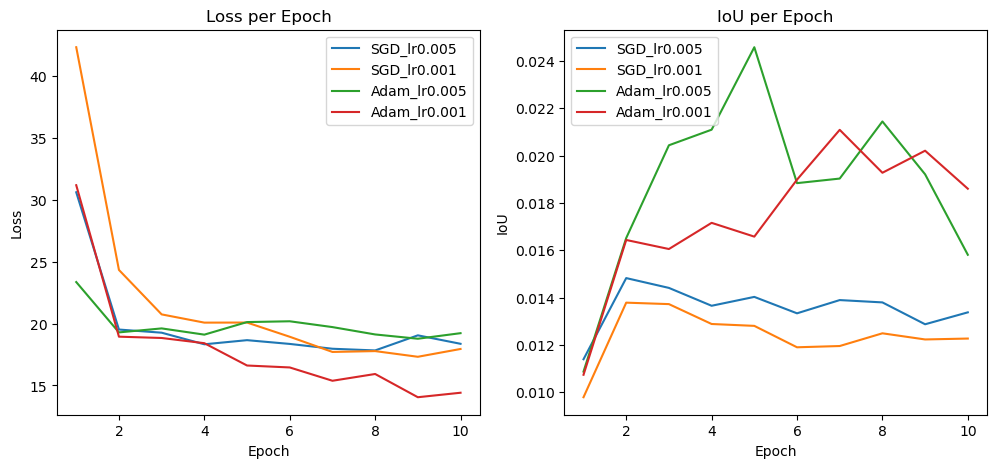

In [ ]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from torchvision.models.detection import ssdlite320_mobilenet_v3_large
from torchvision.ops import box_iou

# Гиперпараметры для экспериментов
num_epochs = 10
learning_rates = [0.01, 0.005, 0.001]  # Разные скорости обучения
optimizers_list = ['SGD', 'Adam', "AdamW", "Adagrad", "ASGD", "Adadelta"]  # Разные оптимизаторы
momentum = 0.9
weight_decay = 0.0005

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Подготовка хранения результатов
results = {}

# Функция вычисления IoU
def calculate_iou(pred_boxes, target_boxes):
    if len(pred_boxes) == 0 or len(target_boxes) == 0:
        return 0
    iou = box_iou(pred_boxes, target_boxes).mean().item()  # Среднее IoU
    return iou

# Цикл по разным параметрам
for opt_type in optimizers_list:
    for lr in learning_rates:
        print(f"\nТренировка {opt_type}, LR : {lr}")

        # Загружаем модель
        model = ssdlite320_mobilenet_v3_large(pretrained=True).to(device)
        model.train()

        # Выбираем оптимизатор
        if opt_type == "SGD":
            optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
        elif opt_type == "Adam":
            optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        elif opt_type == "AdamW":
            optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
        elif opt_type == "Adagrad":
            optimizer = optim.Adagrad(model.parameters(), lr=lr)
        elif opt_type == "ASGD":
            optimizer = optim.ASGD(model.parameters(), lr=lr)
        elif opt_type == "Adadelta":
            optimizer = optim.Adadelta(model.parameters(), lr=lr)


        losses_per_epoch = []
        iou_scores = []

        # Обучение модели
        for epoch in range(num_epochs):
            total_loss = 0
            total_iou = 0
            num_batches = 0

            for images, targets in data_loader:
                images = list(image.to(device) for image in images)

                # Обрабатываем аннотации (валидируем боксы)
                valid_targets = []
                for target in targets:
                    valid_targets.append({
                        'boxes': target['boxes'].to(device),
                        'labels': target['labels'].to(device)
                    })

                # Обнуляем градиенты
                optimizer.zero_grad()

                # Прямой проход
                try:
                    loss_dict = model(images, valid_targets)
                    losses = sum(loss for loss in loss_dict.values())

                    # Обратный проход
                    losses.backward()
                    optimizer.step()

                    total_loss += losses.item()
                    num_batches += 1

                    # Оценка IoU
                    with torch.no_grad():
                        model.eval()
                        output = model(images)  # Получаем предсказания
                        model.train()

                        for i, out in enumerate(output):
                            pred_boxes = out['boxes'].detach()
                            target_boxes = valid_targets[i]['boxes'].detach()

                            iou = calculate_iou(pred_boxes, target_boxes)
                            total_iou += iou

                except Exception as e:
                    print(f"Error during training: {e}")
                    continue

            avg_loss = total_loss / num_batches
            avg_iou = total_iou / num_batches
            losses_per_epoch.append(avg_loss)
            iou_scores.append(avg_iou)

            print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {avg_loss:.4f}, IoU: {avg_iou:.4f}")

        # Сохраняем результаты
        results[f"{opt_type}_lr{lr}"] = (losses_per_epoch, iou_scores)

# Визуализация графиков
plt.figure(figsize=(12, 5))

# График потерь
plt.subplot(1, 2, 1)
for key, (losses, _) in results.items():
    plt.plot(range(1, num_epochs + 1), losses, label=key)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.legend()

# График IoU
plt.subplot(1, 2, 2)
for key, (_, ious) in results.items():
    plt.plot(range(1, num_epochs + 1), ious, label=key)
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.title('IoU per Epoch')
plt.legend()

plt.show()


In [96]:
torch.save(model.state_dict(), "model.pth")


In [97]:
import torch
from torchvision.transforms import functional as F
from torchvision.models.detection import ssdlite320_mobilenet_v3_large

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ssdlite320_mobilenet_v3_large(pretrained=False)  # Создаём модель
model.load_state_dict(torch.load("model.pth", map_location=device))  # Загружаем веса
model.to(device)
model.eval() 


SSD(
  (backbone): SSDLiteFeatureExtractorMobileNet(
    (features): Sequential(
      (0): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (2): Hardswish()
        )
        (1): InvertedResidual(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
              (1): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
              (2): ReLU(inplace=True)
            )
            (1): Conv2dNormActivation(
              (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (1): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
            )
          )
        )
        (2): Invert

In [101]:
from PIL import Image
import matplotlib.pyplot as plt

# Загружаем изображение
image_path = "/home/maksim/develops/python/devsTraining/zala_task/dataset/image/100.jpg"
image = Image.open(image_path).convert("RGB")

# Преобразуем изображение в тензор
image_tensor = F.to_tensor(image).unsqueeze(0).to(device)  # (1, C, H, W)
# Получаем предсказания
with torch.no_grad():
    predictions = model(image_tensor)

# Извлекаем боксы и оценки достоверности
boxes = predictions[0]["boxes"].cpu().numpy()  # Координаты боксов
scores = predictions[0]["scores"].cpu().numpy()  # Уверенность модели

# Фильтруем боксы по порогу уверенности 
threshold = 0.1
filtered_boxes = boxes[scores > threshold]


In [99]:
predictions

[{'boxes': tensor([[1981.0000, 1816.0000, 1981.0000, 1816.0000],
          [1981.0000, 1816.0000, 1981.0000, 1816.0000],
          [1403.6481, 1816.0000, 1632.2502, 1816.0000],
          ...,
          [ 202.7652,  797.5691,  498.0046, 1128.2605],
          [ 896.1140, 1069.9753, 1191.3517, 1400.6432],
          [ 400.8791,  616.0085,  696.0936,  946.6313]], device='cuda:0'),
  'scores': tensor([0.2744, 0.2310, 0.1078, 0.1076, 0.1075, 0.1052, 0.1029, 0.1014, 0.1006,
          0.0999, 0.0999, 0.0999, 0.0999, 0.0999, 0.0999, 0.0999, 0.0999, 0.0998,
          0.0995, 0.0995, 0.0995, 0.0994, 0.0994, 0.0993, 0.0993, 0.0980, 0.0893,
          0.0893, 0.0893, 0.0893, 0.0893, 0.0893, 0.0893, 0.0893, 0.0893, 0.0893,
          0.0893, 0.0893, 0.0893, 0.0893, 0.0893, 0.0893, 0.0893, 0.0871, 0.0869,
          0.0858, 0.0844, 0.0830, 0.0823, 0.0823, 0.0823, 0.0823, 0.0823, 0.0823,
          0.0823, 0.0823, 0.0823, 0.0823, 0.0823, 0.0823, 0.0823, 0.0823, 0.0823,
          0.0821, 0.0821, 0.0821, 0.0

1981.0 1816.0 1981.0 1816.0
1981.0 1816.0 1981.0 1816.0
1403.6481 1816.0 1632.2502 1816.0
609.27954 1816.0 833.7125 1816.0
1008.211 1816.0 1235.9486 1816.0
1874.9108 85.79672 1981.0 220.29442
110.526505 113.879524 249.13322 249.8972
1981.0 1816.0 1981.0 1816.0
195.5865 1816.0 374.1899 1816.0


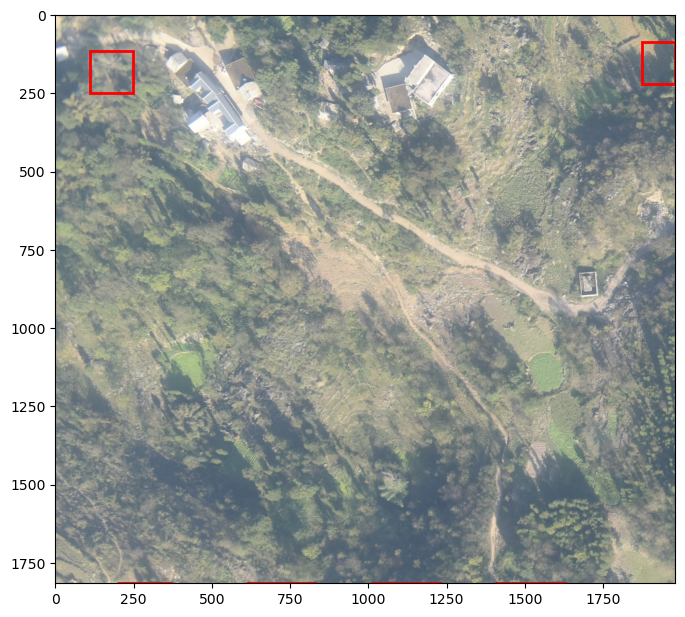

In [102]:
import matplotlib.patches as patches

# Отображаем изображение
fig, ax = plt.subplots(1, figsize=(8, 8))
ax.imshow(image)

# Добавляем боксы
for box in filtered_boxes:
    x_min, y_min, x_max, y_max = box
    rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                             linewidth=2, edgecolor="red", facecolor="none")
    ax.add_patch(rect)
    print(x_min, y_min, x_max, y_max)
plt.show()


## АНАЛИЗ МОДЕЛИ

In [19]:
import torch
from torchvision.models.detection import ssdlite320_mobilenet_v3_large
from fvcore.nn import FlopCountAnalysis, parameter_count_table

# Загружаем предобученную модель
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ssdlite320_mobilenet_v3_large(pretrained=True).to(device)

# Переключаем в режим инференса (обязательно!)
model.eval()

# Создаем тестовый ввод размером (batch_size=1, channels=3, height=320, width=320)
input_tensor = torch.randn(1, 3, 320, 320).to(device)

# Считаем количество операций
flops = FlopCountAnalysis(model, input_tensor)

# Выводим результаты
print(f"Total GFlops: {flops.total() / 1e9:.2f} GFlops")
print(parameter_count_table(model))  # Выводит количество параметров модели


Unsupported operator aten::sub encountered 9 time(s)
Unsupported operator aten::div encountered 21 time(s)
Unsupported operator aten::ceil encountered 2 time(s)
Unsupported operator aten::mul encountered 32 time(s)
Unsupported operator aten::pad encountered 1 time(s)
Unsupported operator aten::hardswish_ encountered 20 time(s)
Unsupported operator aten::add_ encountered 10 time(s)
Unsupported operator aten::hardsigmoid encountered 8 time(s)
Unsupported operator aten::hardtanh_ encountered 24 time(s)
Unsupported operator aten::add encountered 19 time(s)
Unsupported operator aten::meshgrid encountered 6 time(s)
Unsupported operator aten::repeat encountered 6 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::exp encountered 2 time(s)
Unsupported operator aten::min encountered 92 time(s)
Unsupported operator aten::_shape_as_tensor encountered 90 time(s)
Unsupported operator aten::topk encountered 90 time(s)
Unsupported operator prim::CallFunction e

Total GFlops: 0.60 GFlops
| name                                    | #elements or shape   |
|:----------------------------------------|:---------------------|
| model                                   | 3.4M                 |
|  backbone                               |  2.1M                |
|   backbone.features                     |   1.6M               |
|    backbone.features.0                  |    0.9M              |
|    backbone.features.1                  |    0.8M              |
|   backbone.extra                        |   0.5M               |
|    backbone.extra.0                     |    0.3M              |
|    backbone.extra.1                     |    0.1M              |
|    backbone.extra.2                     |    67.7K             |
|    backbone.extra.3                     |    25.7K             |
|  head                                   |  1.4M                |
|   head.classification_head              |   1.3M               |
|    head.classification_head.module

In [6]:
import torch  
from torchvision.models.detection import ssdlite320_mobilenet_v3_large  
from torchprofile import profile_macs  

# Загрузка модели  
device = "cpu" 
model = ssdlite320_mobilenet_v3_large(pretrained=True).to(device)  

# Установка модели в режим оценки, отключение градиентов  
model.eval()  

# Создание тестового входного тензора  
input_tensor = torch.randn(1, 3, 512, 512).to(device)  

# Профилирование модели для подсчета MACs  
macs = profile_macs(model, input_tensor)  
gflops = macs / 1e9  # переведение в GFLOPs  
 
device = "cuda" 
macs = profile_macs(model, input_tensor)  
gflops = macs / 1e9  # переведение в GFLOPs  

print(f"GFLOPs на Cuda: {gflops:.2f}")

print(f"GFLOPs на CPU: {gflops:.2f}")  

GFLOPs на Cuda: 0.60
GFLOPs на CPU: 0.60


In [8]:
import torch  
import torch.nn as nn  
from torchvision.models.detection import ssdlite320_mobilenet_v3_large  

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  
model = ssdlite320_mobilenet_v3_large(pretrained=True).to(device)  

# Параметры входных данных  
input_tensor = torch.randn(1, 3, 320, 320).to(device)  # 1 изображение размером 320x320  

# Первая отправка через модель для проверки выходных данных  
model.eval()  # Установка в режим оценки  
with torch.no_grad():  # Отключаем градиенты  
    output = model(input_tensor)  

# Вывод информации о выходах  
print("Output:", output)  # Вывод информации о выходах  

# Вывод параметров модели  
print("Total parameters:", sum(p.numel() for p in model.parameters()))  
print("Trainable parameters:", sum(p.numel() for p in model.parameters() if p.requires_grad))  


Output: [{'boxes': tensor([[ 10.8309,   9.2505, 293.9546, 318.4692],
        [ 10.1021,   6.6071, 292.0480, 318.9286],
        [ 11.2432,  28.1390, 290.2533, 318.2936],
        ...,
        [101.6973,  34.4321, 172.2271,  75.1670],
        [222.9227,  19.3669, 317.9391, 246.8920],
        [263.9545, 143.1682, 319.4971, 217.5221]], device='cuda:0'), 'scores': tensor([0.2876, 0.1966, 0.1437, 0.0929, 0.0690, 0.0639, 0.0632, 0.0575, 0.0568,
        0.0549, 0.0538, 0.0525, 0.0524, 0.0522, 0.0509, 0.0501, 0.0498, 0.0496,
        0.0491, 0.0487, 0.0479, 0.0475, 0.0470, 0.0463, 0.0458, 0.0443, 0.0439,
        0.0437, 0.0432, 0.0430, 0.0429, 0.0428, 0.0426, 0.0424, 0.0422, 0.0406,
        0.0406, 0.0406, 0.0401, 0.0400, 0.0395, 0.0394, 0.0391, 0.0390, 0.0389,
        0.0388, 0.0387, 0.0383, 0.0382, 0.0382, 0.0378, 0.0377, 0.0369, 0.0368,
        0.0362, 0.0360, 0.0357, 0.0351, 0.0350, 0.0349, 0.0349, 0.0348, 0.0347,
        0.0343, 0.0338, 0.0337, 0.0337, 0.0333, 0.0332, 0.0332, 0.0330, 0.0330,

In [10]:
model

SSD(
  (backbone): SSDLiteFeatureExtractorMobileNet(
    (features): Sequential(
      (0): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (2): Hardswish()
        )
        (1): InvertedResidual(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
              (1): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
              (2): ReLU(inplace=True)
            )
            (1): Conv2dNormActivation(
              (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (1): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
            )
          )
        )
        (2): Invert